In [1]:
import scanpy as scp
import scvelo as scv

import cy2path as c2p

import seaborn as sns
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Import data from scvelo
adata = scv.datasets.forebrain()

Filtered out 22514 genes that are detected 30 counts (spliced).
Filtered out 6 genes that are detected in less than 20 cells (spliced).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.
computing neighbors
    finished (0:00:12) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 8/8 cores)


  0%|          | 0/1720 [00:00<?, ?cells/s]

    finished (0:00:06) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)


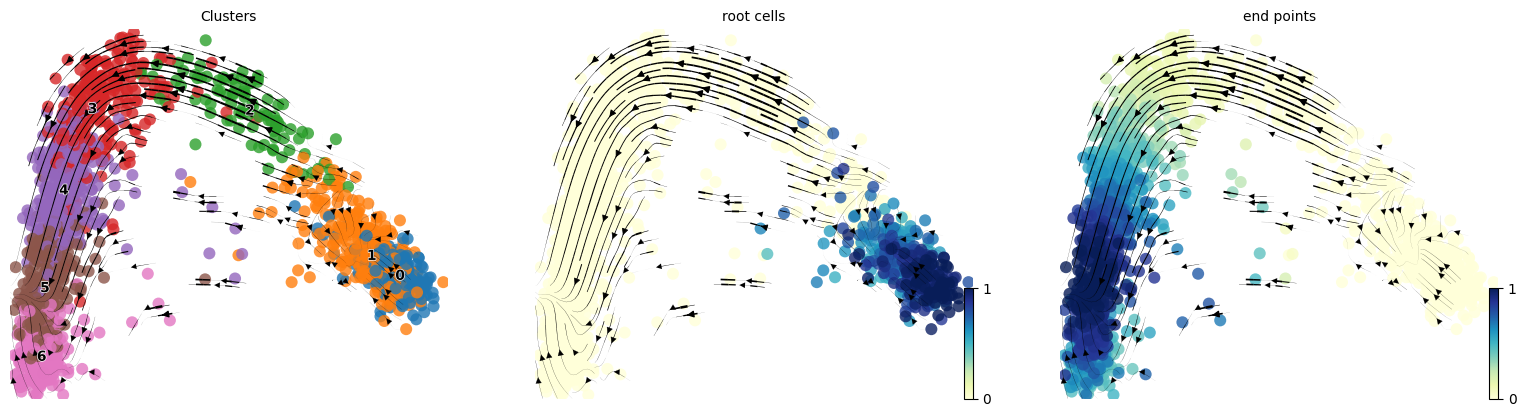

In [3]:
# Preprocess data
scv.pp.filter_genes(adata, min_counts=30)
scv.pp.filter_genes(adata, min_cells=20)

# Normalise data
scv.pp.filter_and_normalize(adata, 
                            flavor='cell_ranger', 
                            n_top_genes=2000)
scv.pp.moments(adata, n_neighbors=200)

# Perform velocity analysis
scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata, n_jobs=-1)
scv.tl.terminal_states(adata)

# Store the transition probability matrix
adata.obsp['T_forward'] = scv.utils.get_transition_matrix(adata, self_transitions=False)

# Plot velocity embedding on PCA
scv.pl.velocity_embedding_stream(adata, 
                                 color=['Clusters', 
                                        'root_cells', 
                                        'end_points'],
                                 color_map='YlGnBu',
                                 alpha=0.8,
                                 size=300,
                                 show=True)

Iterating state probability distributions:   0%|          | 0/1000 [00:00<?, ?it/s]

INFO:root:Tolerance reached after 119 iterations of 1000.


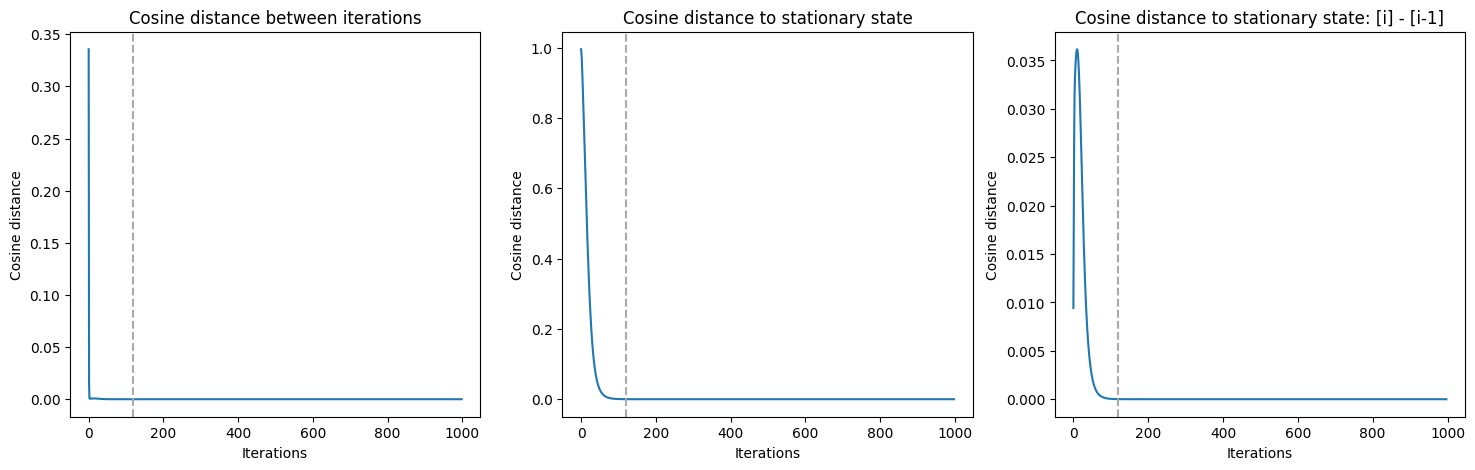

In [4]:
# Run state probability sampling using TPM stored earlier
c2p.sample_state_probability(adata, 
                             matrix_key='T_forward',
                             recalc_matrix=False)
c2p.plot_distances(adata, log=False)

In [5]:
# Train the lineage inference model
model = c2p.infer_latent_dynamics(adata, use_gpu=True, verbose=True)

Training dynamic model:   0%|          | 0/500 [00:00<?, ?it/s]

0.38s. It 1 Loss 3.27E+00 KL 5.98E-01 Likl -4.51E+02 Sparse 2.63E+00 Orth 4.23E-01 Corcoef -0.00
0.51s. It 2 Loss 9.11E-01 KL 6.26E-01 Likl -4.86E+02 Sparse 2.49E-01 Orth 3.58E-01 Corcoef 0.61
0.62s. It 3 Loss 5.83E-01 KL 4.56E-01 Likl -4.46E+02 Sparse 9.79E-02 Orth 2.94E-01 Corcoef 0.60
0.73s. It 4 Loss 3.87E-01 KL 3.01E-01 Likl -5.47E+02 Sparse 6.65E-02 Orth 1.99E-01 Corcoef 0.64
0.84s. It 5 Loss 2.76E-01 KL 1.93E-01 Likl -5.35E+02 Sparse 5.49E-02 Orth 2.79E-01 Corcoef 0.77
0.95s. It 6 Loss 2.84E-01 KL 2.21E-01 Likl -4.98E+02 Sparse 3.68E-02 Orth 2.61E-01 Corcoef 0.68
1.07s. It 7 Loss 3.68E-01 KL 2.57E-01 Likl -5.27E+02 Sparse 8.75E-02 Orth 2.33E-01 Corcoef 0.75
1.18s. It 8 Loss 1.95E-01 KL 1.33E-01 Likl -6.13E+02 Sparse 3.99E-02 Orth 2.17E-01 Corcoef 0.87
1.29s. It 9 Loss 1.28E-01 KL 7.17E-02 Likl -5.78E+02 Sparse 3.44E-02 Orth 2.19E-01 Corcoef 0.93
1.41s. It 10 Loss 1.15E-01 KL 6.61E-02 Likl -6.02E+02 Sparse 2.69E-02 Orth 2.23E-01 Corcoef 0.95
8.79s. It 100 Loss 5.40E-02 KL 2.61E-0

In [6]:
# Get kinetic clustering
c2p.infer_kinetic_clusters(adata)

# Get state transitions
c2p.infer_latent_paths(adata)

# Estimate simulation based pseudotime
c2p.infer_pseudotime(adata)

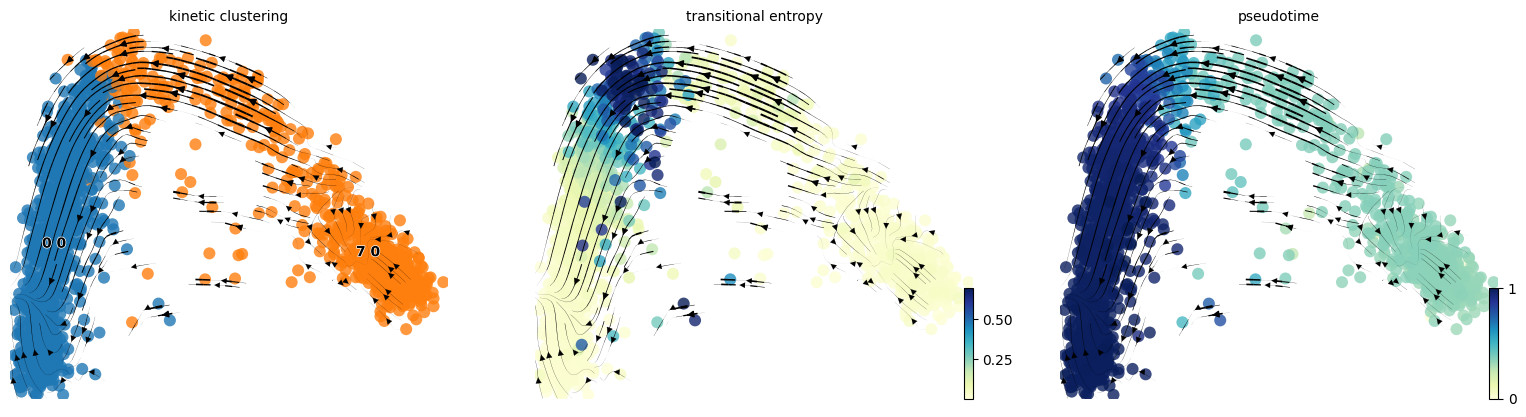

In [7]:
# Plot simulation pseudotime, kinetic clustering, transition entropy
scv.pl.velocity_embedding_stream(adata, 
                                 color=['kinetic_clustering', 
                                        'transitional_entropy', 
                                        'pseudotime'], 
                                 color_map='YlGnBu',
                                 alpha=0.8,
                                 size=300,
                                 show=True)

Text(0, 0.5, 'Simulation pseudotime')

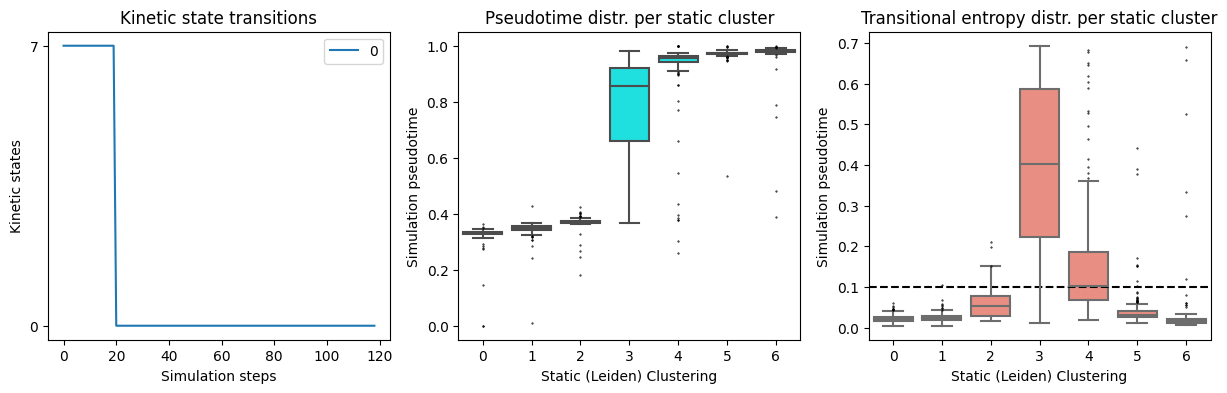

In [8]:
# Plot distribution over clusters
fig, axs = plt.subplots(ncols=3, figsize=(15,4))

# Latent state transitions
c2p.plot_latent_transitions(adata, ax=axs[0])
axs[0].set_title('Kinetic state transitions')
axs[0].set_xlabel('Simulation steps')
axs[0].set_ylabel('Kinetic states')

# Simulation pseudotime
c2p.plot_annotation_boxplots(adata, 
                             categorical='Clusters', 
                             continous='pseudotime', 
                             color='cyan', 
                             ax=axs[1])
axs[1].set_title('Pseudotime distr. per static cluster')
axs[1].set_xlabel('Static (Leiden) Clustering')
axs[1].set_ylabel('Simulation pseudotime')

# Transitional entropy
ax=c2p.plot_annotation_boxplots(adata, 
                                categorical='Clusters', 
                                continous='transitional_entropy', 
                                color='salmon', 
                                order=adata.obs.groupby('Clusters')['pseudotime'].mean().fillna(0).sort_values().index, 
                                ax=axs[2])
axs[2].hlines(0.1, -0.5, 6.5, linestyles='dashed', color='black')

axs[2].set_title('Transitional entropy distr. per static cluster')
axs[2].set_xlabel('Static (Leiden) Clustering')
axs[2].set_ylabel('Simulation pseudotime')

(<Figure size 2000x350 with 8 Axes>,
 array([<AxesSubplot:title={'center':'Hidden state prob. 0'}>,
        <AxesSubplot:title={'center':'Hidden state memb. 0'}>,
        <AxesSubplot:title={'center':'Hidden state prob. 7'}>,
        <AxesSubplot:title={'center':'Hidden state memb. 7'}>],
       dtype=object))

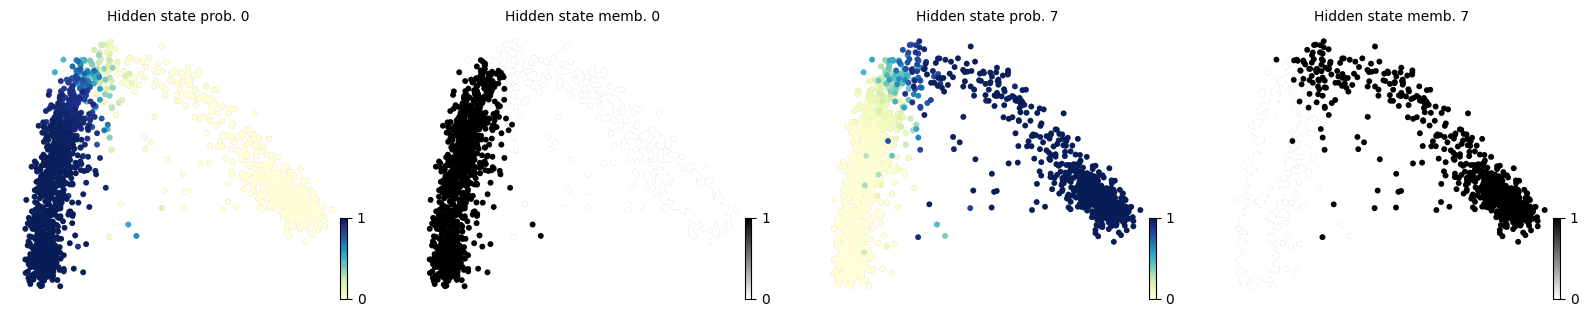

In [9]:
# Plot latent state emissions
c2p.plot_latent_summary(adata, basis='pca', use_selected=True)

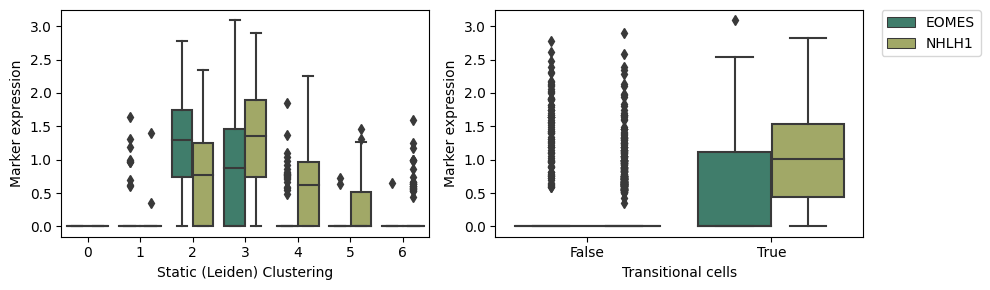

In [10]:
# Distribution of EOMES and NHLH1
adata.obs['transitional_cells'] = (adata.obs.transitional_entropy>=0.1).astype('category')

df = adata.obs.copy()
df['EOMES'] = adata[:, 'EOMES'].X.toarray()
df['NHLH1'] = adata[:, 'NHLH1'].X.toarray()

fig, axs = plt.subplots(ncols=2, figsize=(10,3))

# Expression vs Clusters
sns.boxplot(x='Clusters', y='value', hue='variable', 
            data=df.loc[:, ['Clusters', 'EOMES', 'NHLH1']].melt(id_vars='Clusters'), 
            palette='gist_earth', ax=axs[0])
axs[0].get_legend().set_visible(False)
axs[0].set_xlabel('Static (Leiden) Clustering')
axs[0].set_ylabel('Marker expression')

# Expression vs transitional 
sns.boxplot(x='transitional_cells', y='value', hue='variable', 
            data=df.loc[:, ['transitional_cells', 'EOMES', 'NHLH1']].melt(id_vars='transitional_cells') , 
            palette='gist_earth', ax=axs[1])
axs[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
axs[1].set_xlabel('Transitional cells')
axs[1].set_ylabel('Marker expression')

plt.tight_layout()